In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
dist_stats = pd.read_csv('data/dist_stats.csv', encoding='cp949')

In [224]:
dist_stats.columns

Index(['상권_코드', '2019-Q4', '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4',
       '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1', '2022-Q2',
       '2022-Q3', '2022-Q4', 'y_pred_3_euc', 'y_pred_4_euc', 'y_pred_6_euc',
       'y_pred_3_dtw', 'y_pred_4_dtw', 'y_pred_6_dtw', 'Covid_local_min',
       't_recovery', 'd_resistance', 'd_recovery', 'd_stability', 'drop',
       'rebound', 'res_ratio', 'resilience', '개인교통_비율', '교육_비율', '기타_비율',
       '리빙_비율', '뷰티_비율', '숙박_비율', '온라인판매_비율', '외식업_비율', '의료기기_비율', '패션소품_비율',
       '편의점_비율', '홈쿡_비율', '병원_비율', '스포츠_비율', '실내다중_비율', '인테리어_비율', '부동산_비율'],
      dtype='object')

In [225]:
# DTW 기반 3개 군집 사용 결정 
dist_stats['cluster'] = dist_stats['y_pred_3_dtw']

In [226]:
cluster_dict = dict(zip(dist_stats['상권_코드'], dist_stats['cluster']))

### 이분산성 체크

In [227]:
from scipy.stats import bartlett

In [228]:
bartlett(dist_stats[dist_stats['cluster'] == 0]['외식업_비율'],
         dist_stats[dist_stats['cluster'] == 1]['외식업_비율'],
         dist_stats[dist_stats['cluster'] == 2]['외식업_비율'])

BartlettResult(statistic=12.269428204925942, pvalue=0.002166344481909233)

## 업종 비율

In [229]:
SECTOR_RATIO_FEATURES =  ['개인교통_비율', '교육_비율', '기타_비율', '리빙_비율', '뷰티_비율', '숙박_비율', '온라인판매_비율',
       '외식업_비율', '의료기기_비율', '패션소품_비율', '편의점_비율', '홈쿡_비율', '병원_비율', '스포츠_비율',
       '실내다중_비율', '인테리어_비율', '부동산_비율']

In [230]:
import pingouin as pg 

np2 해석
0.01 스몰
0.06 미디엄
0.14 크다

라고 일단 볼 수 있음
[링크](https://resources.nu.edu/statsresources/eta)

In [231]:
def get_sig_columns(df, cluster_dict, features, p_value=0.05):
    df = df[df["상권_코드"].isin(cluster_dict.keys())].copy()
    df["cluster"] = df["상권_코드"].map(cluster_dict)

    rows_list = []
    for feature in features:
        anova_res = pg.welch_anova(dv=feature, between="cluster", data=df)
        if anova_res["p-unc"][0] < p_value:
            # Create a dictionary for each row
            row_dict = {
                "sig_column": feature,
                "p_value": anova_res["p-unc"][0],
                "F": anova_res["F"][0],
                "np2": anova_res["np2"][0],
            }
            gameshowell_res = pg.pairwise_gameshowell(
                dv=feature, between="cluster", data=df
            )
            for i in range(len(gameshowell_res)):
                row_dict[f"{gameshowell_res['A'][i]}, {gameshowell_res['B'][i]}_p"] = (
                    gameshowell_res["pval"][i]
                )
                row_dict[
                    f"{gameshowell_res['A'][i]}, {gameshowell_res['B'][i]}_hedge"
                ] = gameshowell_res["hedges"][i]
                row_dict[
                    f'{gameshowell_res["A"][i]}, {gameshowell_res["B"][i]}_diff'
                ] = gameshowell_res["diff"][i]

            rows_list.append(row_dict)
    res_df = pd.DataFrame(rows_list)

    return res_df

In [ ]:
sector_ratio_sg = get_sig_columns(dist_stats, cluster_dict, SECTOR_RATIO_FEATURES)

In [233]:
sector_ratio_sg

,sig_column,p_value,F,np2,"0, 1_p","0, 1_hedge","0, 1_diff","0, 2_p","0, 2_hedge","0, 2_diff","1, 2_p","1, 2_hedge","1, 2_diff"
0,개인교통_비율,5.516070e-05,9.939348,0.021767,0.005727,0.227584,0.021229,4.905450e-05,0.325041,0.028690,1.285725e-01,0.132866,0.007461
1,외식업_비율,3.145595e-21,50.094334,0.068880,0.002350,0.242115,0.046411,2.031251e-07,-0.383313,-0.075294,2.250422e-13,-0.672145,-0.121706
2,편의점_비율,5.257499e-04,7.628441,0.009760,0.913926,-0.028971,-0.004155,1.999355e-02,0.195951,0.023615,1.825605e-03,0.238470,0.027769
3,홈쿡_비율,6.472575e-11,24.197265,0.037006,0.002339,-0.239063,-0.042985,5.141652e-03,0.224117,0.032966,4.351397e-11,0.476749,0.075950
4,병원_비율,1.901746e-03,6.313093,0.010478,0.873137,-0.035475,-0.003070,3.255911e-03,-0.225120,-0.020411,1.265798e-02,-0.191961,-0.017341
5,실내다중_비율,2.455114e-05,10.753980,0.015319,0.215606,-0.117753,-0.003044,1.225930e-05,-0.308483,-0.008410,2.819841e-02,-0.173437,-0.005365


In [234]:
anova_res = sector_ratio_sg.copy()

In [235]:
plt.rcParams["font.family"] = "Malgun Gothic"

In [236]:
def draw_kde(df, cluster_dict, features):
    df = df[df["상권_코드"].isin(cluster_dict.keys())].copy()
    df["cluster"] = df["상권_코드"].map(cluster_dict)
    df["cluster"] = df["cluster"].map({0: "A", 1: "B", 2: "C"})

    sns.set_theme(style="whitegrid")
    for feature in features:
        # set 5, 95 percentile
        xlim = np.percentile(df[feature], [5, 95])
        plt.figure(figsize=(20, 5))
        plt.rcParams["font.family"] = "Malgun Gothic"
        for cluster in sorted(df["cluster"].unique()):
            sns.kdeplot(
                data=df[df["cluster"] == cluster],
                x=feature,
                fill=True,
                alpha=0.5,
                label=cluster,
            )
        plt.title(feature)
        plt.xlim(xlim[0], xlim[1])
        plt.legend()
        plt.savefig(
            f'img/kde_{feature}_cluster_{len(df["cluster"].unique())}.svg', format="svg")

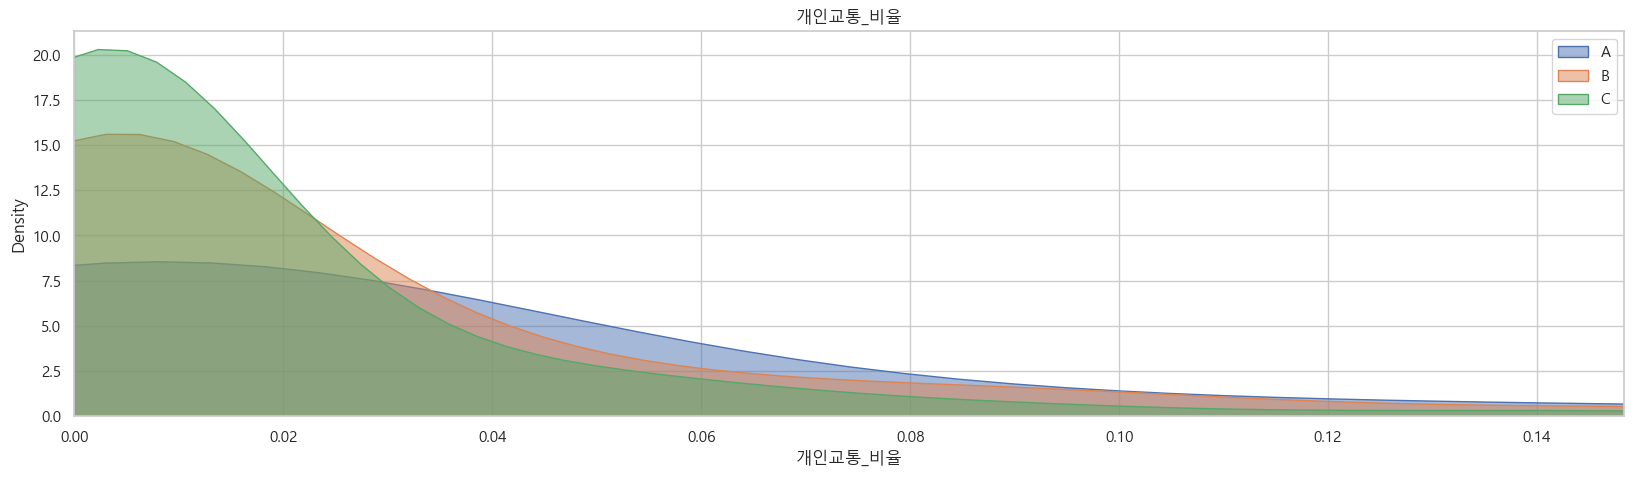

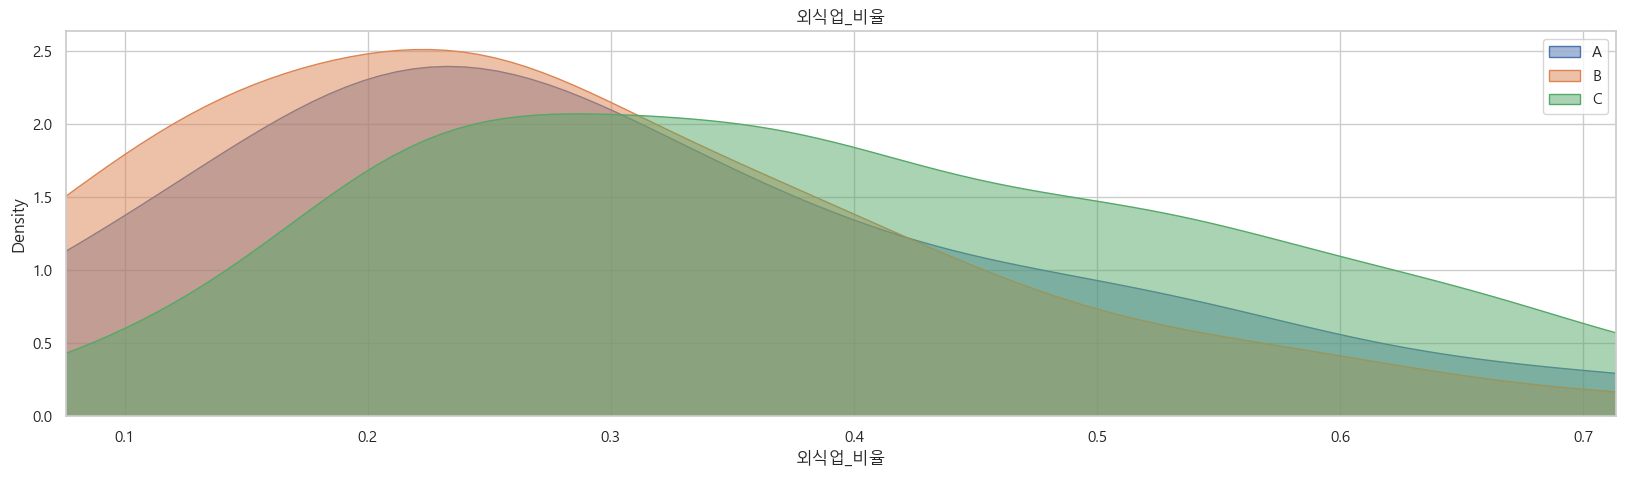

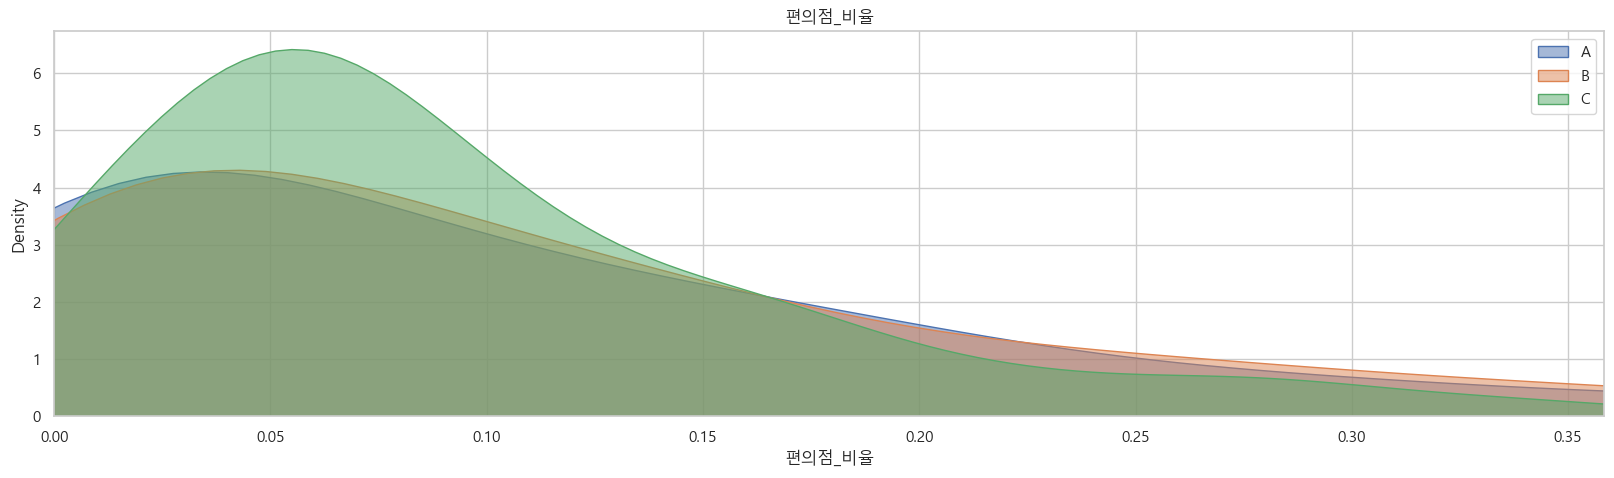

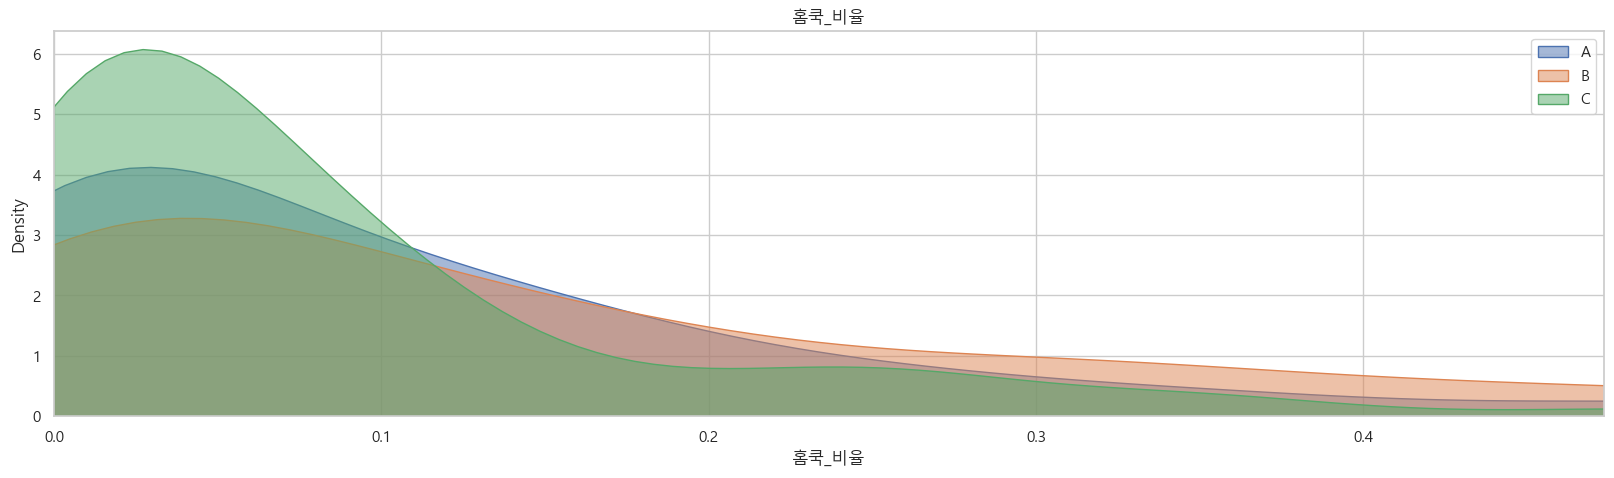

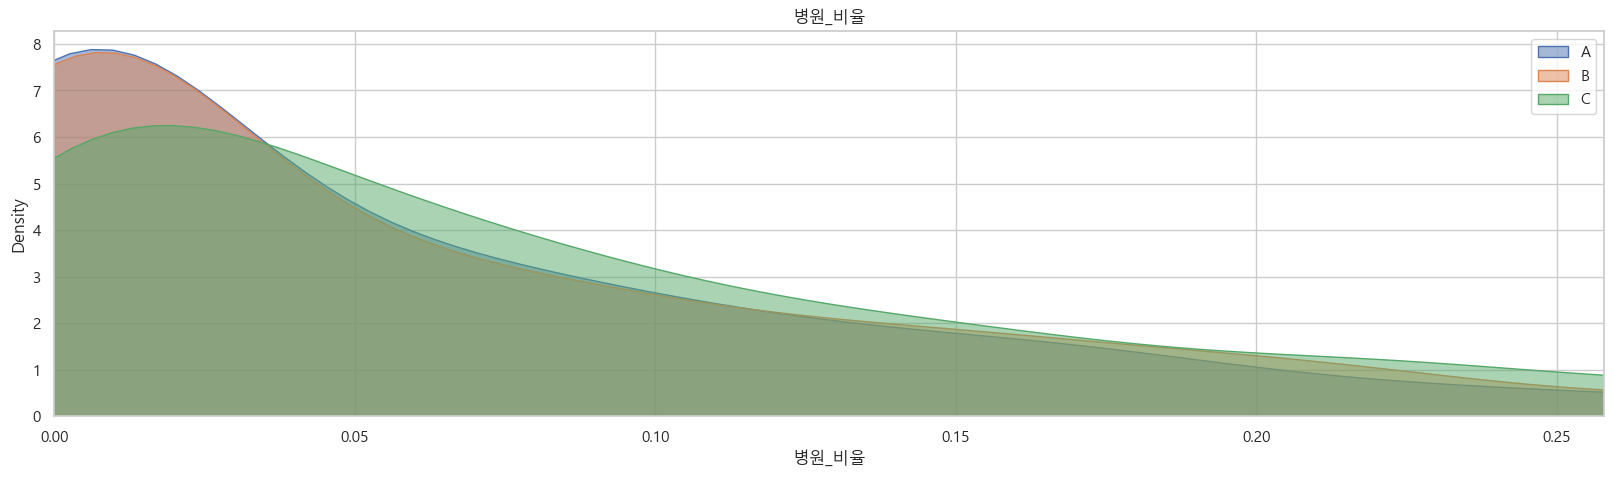

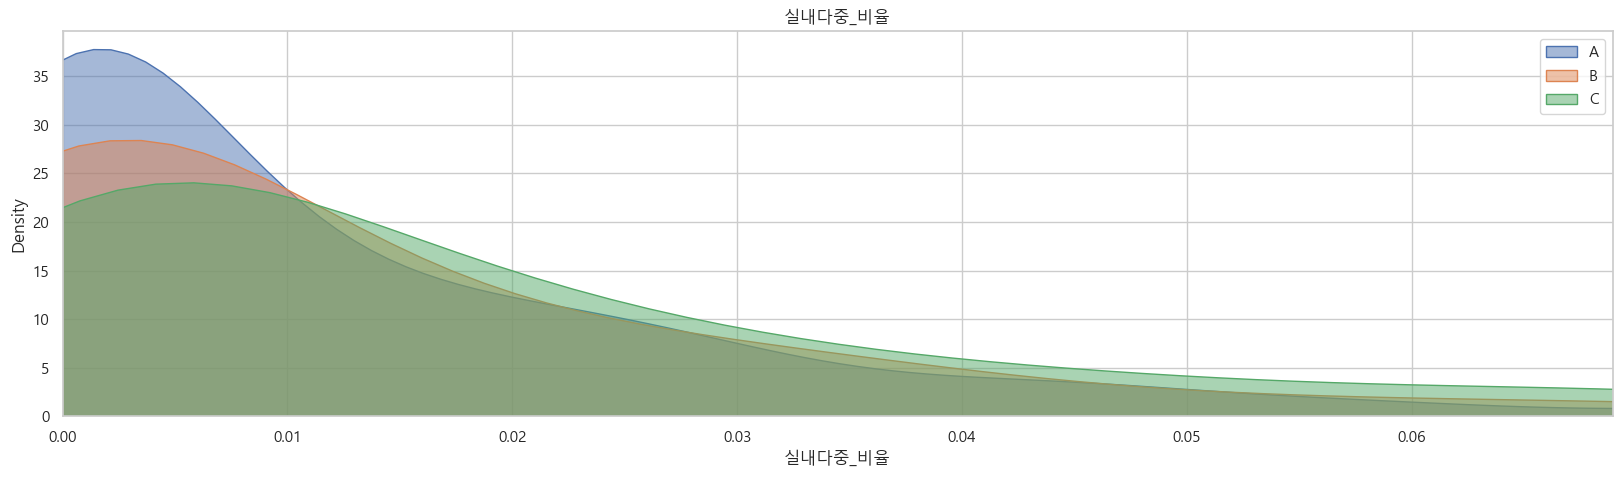

In [237]:
draw_kde(dist_stats, cluster_dict, sector_ratio_sg['sig_column'].to_list())

## 상권 구분

In [238]:
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [239]:
categ_df = pd.read_csv('data/상권-상권영역.csv', encoding='cp949')

In [240]:
categ_df.head(2)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드
0,202212,A,골목상권,3110008,배화여자대학교(박노수미술관),197093,453418,11110,11110515
1,202212,A,골목상권,3110009,자하문터널,196991,455057,11110,11110550


In [241]:
CATEGORY_FEATURES = ["상권_구분_코드_명"]

In [242]:
categ_df['cluster'] = categ_df['상권_코드'].map(cluster_dict)

In [243]:
contingency_table = pd.crosstab(categ_df['cluster'], categ_df['상권_구분_코드_명'])

In [244]:
def get_sig_columns_categorical(df, cluster_dict, features, p_value=0.05):

    df = df[df["상권_코드"].isin(cluster_dict.keys())].copy()
    df["cluster"] = df["상권_코드"].map(cluster_dict)

    rows_list = []
    for feature in features:
        contingency_table = pd.crosstab(df["cluster"], df[feature])
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        if p < p_value:
            n = contingency_table.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
            # Create a dictionary for each row
            row_dict = {
                "sig_column": feature,
                "p_value": p,
                "chi2": chi2,
                "cramers_v": cramer_v,
            }

            # If the size is reasonable, add to the columns
            if len(df[feature].unique()) <= 5:
                for i, col in enumerate(contingency_table.columns):
                    row_dict[f"분포_{i}"] = (
                        f"{col}: {[contingency_table[col][cluster] for cluster in contingency_table.index]}"
                    )
            rows_list.append(row_dict)
    res_df = pd.DataFrame(rows_list)

    return res_df

In [245]:
dist_category_sg = get_sig_columns_categorical(categ_df, cluster_dict, CATEGORY_FEATURES)
dist_category_sg

,sig_column,p_value,chi2,cramers_v,분포_0,분포_1
0,상권_구분_코드_명,1.176250e-13,59.542549,0.21869,"골목상권: [322, 358, 318]","발달상권: [52, 51, 144]"


In [246]:
def draw_stacked_bar(df, cluster_dict, features):
    df = df[df['상권_코드'].isin(cluster_dict.keys())].copy()
    df['cluster'] = df['상권_코드'].map(cluster_dict)
    for feature in features:
        contingency_table = pd.crosstab(df['cluster'], df[feature])
        contingency_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        contingency_table.plot(kind='bar', stacked=True, figsize=(10, 5), color= ['#FE9D52', '#3C97DA', '#84B29E'])
        plt.title(feature)
        plt.xticks(rotation=0)
        plt.legend(labels=contingency_table.columns)
        plt.savefig(f'img/stacked_bar_{feature}_cluster_{len(df["cluster"].unique())}.svg', format='svg')

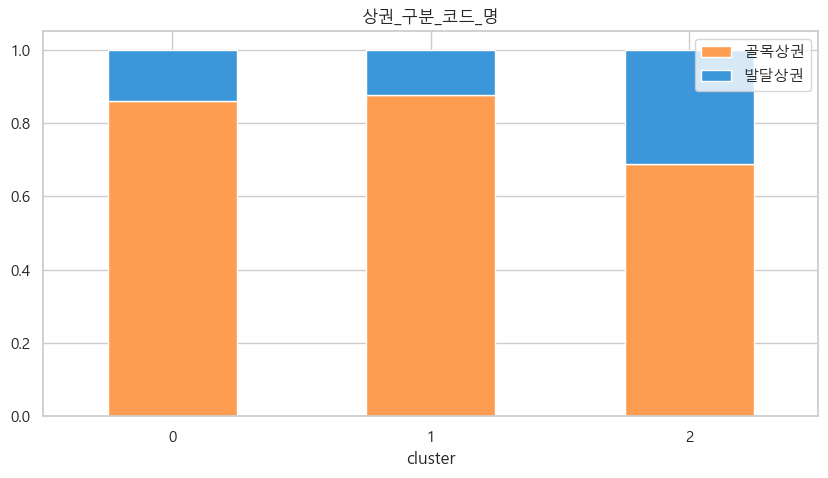

In [247]:
draw_stacked_bar(categ_df, cluster_dict, dist_category_sg['sig_column'].to_list())

In [248]:
chi_res = dist_category_sg.copy()

## Resilience

In [249]:
RESILIENCE_FEATURES = ['drop', 'rebound', 'resilience']

In [250]:
resilience_sig = get_sig_columns(dist_stats, cluster_dict, RESILIENCE_FEATURES)
resilience_sig

,sig_column,p_value,F,np2,"0, 1_p","0, 1_hedge","0, 1_diff","0, 2_p","0, 2_hedge","0, 2_diff","1, 2_p","1, 2_hedge","1, 2_diff"
0,drop,7.877231e-64,174.939959,0.185594,0.000000e+00,-0.844491,-0.111447,8.788525e-13,-1.256828,-0.143218,0.001580,-0.238963,-0.031771
1,rebound,1.325455e-20,49.022553,0.111972,0.000000e+00,0.713148,0.158527,2.128298e-13,0.654949,0.126402,0.003202,-0.228776,-0.032125
2,resilience,5.075180e-65,190.984094,0.279213,1.196820e-13,1.095371,1.138452,1.503242e-13,1.480070,1.163882,0.869370,0.035850,0.025430


In [ ]:
draw_kde(dist_stats, cluster_dict, resilience_sig['sig_column'].to_list())

In [ ]:
anova_res = anova_res.append(resilience_sig)

In [253]:
def analyze_clusters(df, continuous_features, categorical_features, cont_res, cat_res,  cluster_dict=cluster_dict):
    if continuous_features:
        sig_df = get_sig_columns(df, cluster_dict, continuous_features)
        draw_kde(df, cluster_dict, sig_df['sig_column'].to_list())
        cont_res = cont_res.append(sig_df)    
    if categorical_features:
        sig_df = get_sig_columns_categorical(df, cluster_dict, categorical_features)
        draw_stacked_bar(df, cluster_dict, sig_df['sig_column'].to_list())
        cat_res = cat_res.append(sig_df)
    return cont_res, cat_res

## 상권-상주인구

In [254]:
resident_pop = pd.read_csv('data/상권-상주인구(YU).csv', encoding='cp949')
resident_pop.head(2)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권 코드,총 상주인구 수,남성 상주인구 수,여성 상주인구 수,연령대 10 상주인구 수,연령대 20 상주인구 수,...,여성연령대 10 상주인구 수,여성연령대 20 상주인구 수,여성연령대 30 상주인구 수,여성연령대 40 상주인구 수,여성연령대 50 상주인구 수,여성연령대 60 이상 상주인구 수,총 가구 수,아파트 가구 수,비 아파트 가구 수,상권 코드 명
0,2023,1,U,관광특구,3001496,19,11,8,6,0,...,3,0,1,2,0,2,10,0,10,강남 마이스 관광특구
1,2023,1,U,관광특구,3001495,5902,2885,3017,572,462,...,253,239,637,597,443,848,2964,0,2964,잠실 관광특구


In [255]:
resident_pop.columns

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권 코드', '총 상주인구 수',
       '남성 상주인구 수', '여성 상주인구 수', '연령대 10 상주인구 수', '연령대 20 상주인구 수',
       '연령대 30 상주인구 수', '연령대 40 상주인구 수', '연령대 50 상주인구 수', '연령대 60 이상 상주인구 수',
       '남성연령대 10 상주인구 수', '남성연령대 20 상주인구 수', '남성연령대 30 상주인구 수',
       '남성연령대 40 상주인구 수', '남성연령대 50 상주인구 수', '남성연령대 60 이상 상주인구 수',
       '여성연령대 10 상주인구 수', '여성연령대 20 상주인구 수', '여성연령대 30 상주인구 수',
       '여성연령대 40 상주인구 수', '여성연령대 50 상주인구 수', '여성연령대 60 이상 상주인구 수', '총 가구 수',
       '아파트 가구 수', '비 아파트 가구 수', '상권 코드 명'],
      dtype='object')

In [256]:
resident_pop = resident_pop[(resident_pop["기준_년_코드"] == 2019) & (resident_pop["기준_분기_코드"] == 4)]

In [257]:
resident_pop.rename(columns={'상권 코드': '상권_코드'}, inplace=True)

In [258]:
resident_pop = resident_pop[['상권_코드', '총 상주인구 수', '연령대 10 상주인구 수', '연령대 20 상주인구 수',
       '연령대 30 상주인구 수', '연령대 40 상주인구 수', '연령대 50 상주인구 수', '연령대 60 이상 상주인구 수','아파트 가구 수', '총 가구 수']]

In [259]:
AGES = ['연령대 10 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '연령대 40 상주인구 수', '연령대 50 상주인구 수', '연령대 60 이상 상주인구 수']

In [260]:
for age_str in AGES:
    age = age_str.split(' ')[1]
    resident_pop[f'상주인구_{age}대_비율'] = resident_pop[age_str] / resident_pop['총 상주인구 수']

In [261]:
resident_pop['아파트_가구_비율'] = resident_pop['아파트 가구 수'] / resident_pop['총 상주인구 수']

In [262]:
resident_pop.head(2)

,상권_코드,총 상주인구 수,연령대 10 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,연령대 40 상주인구 수,연령대 50 상주인구 수,연령대 60 이상 상주인구 수,아파트 가구 수,총 가구 수,상주인구_10대_비율,상주인구_20대_비율,상주인구_30대_비율,상주인구_40대_비율,상주인구_50대_비율,상주인구_60대_비율,아파트_가구_비율
21208,1001496,24,6,2,2,3,5,6,0,13,0.250000,0.083333,0.083333,0.125000,0.208333,0.250000,0.0
21209,1001495,8221,822,1679,2063,1139,997,1521,0,4837,0.099988,0.204233,0.250943,0.138548,0.121275,0.185014,0.0


In [263]:
resident_pop.columns

Index(['상권_코드', '총 상주인구 수', '연령대 10 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수',
       '연령대 40 상주인구 수', '연령대 50 상주인구 수', '연령대 60 이상 상주인구 수', '아파트 가구 수',
       '총 가구 수', '상주인구_10대_비율', '상주인구_20대_비율', '상주인구_30대_비율', '상주인구_40대_비율',
       '상주인구_50대_비율', '상주인구_60대_비율', '아파트_가구_비율'],
      dtype='object')

In [264]:
resident_pop['상권_코드'] = resident_pop['상권_코드'] + 1000000

In [265]:
RESIDENT_POP_FEATURES = ['총 상주인구 수', '총 가구 수', 
                         '상주인구_10대_비율', '상주인구_20대_비율', '상주인구_30대_비율', '상주인구_40대_비율', '상주인구_50대_비율', '상주인구_60대_비율', 
                         '아파트_가구_비율']

In [ ]:
anova_res, _ = analyze_clusters(resident_pop, RESIDENT_POP_FEATURES, None, anova_res, None)

## 상권-생활인구


시간대 1부터 6까지 각각 00~06시, 06~11시, 11~14시, 14~17시, 17~21시, 21~24시 

In [268]:
defacto_pop = pd.read_csv('data/상권-생활인구(QU).csv', encoding='cp949')

In [269]:
defacto_pop.head(2)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2023,1,U,관광특구,3001496,강남 마이스 관광특구,109623,55025,54598,8151,...,175,175,139,40,49,108,156,149,121,38
1,2023,1,U,관광특구,3001495,잠실 관광특구,4186941,2027264,2159678,488085,...,7614,7867,9198,4856,8071,7975,7221,7257,8481,4669


In [270]:
defacto_pop.columns.tolist()

['기준 년코드',
 '기준_분기_코드',
 '상권_구분_코드',
 ' 상권_구분_코드_명',
 '상권_코드',
 '상권_코드_명',
 '총_생활인구_수',
 '남성_생활인구_수',
 '여성_생활인구_수',
 '연령대_10_생활인구_수',
 '연령대_20_생활인구_수',
 '연령대_30_생활인구_수',
 '연령대_40_생활인구_수',
 '연령대_50_생활인구_수',
 '연령대_60_이상_생활인구_수',
 '시간대_1_생활인구_수',
 '시간대_2_생활인구_수',
 '시간대_3_생활인구_수',
 '시간대_4_생활인구_수',
 '시간대_5_생활인구_수',
 '시간대_6_생활인구_수',
 '월요일_생활인구_수',
 '화요일_생활인구_수',
 '수요일_생활인구_수',
 '목요일_생활인구_수',
 '금요일_생활인구_수',
 '토요일_생활인구_수',
 '일요일_생활인구_수',
 '남성연령대_10_월요일시간대_1_생활인구_수',
 '남성연령대_10_월요일시간대_2_생활인구_수',
 '남성연령대_10_월요일시간대_3_생활인구_수',
 '남성연령대_10_월요일시간대_4_생활인구_수',
 '남성연령대_10_월요일시간대_5_생활인구_수',
 '남성연령대_10_월요일시간대_6_생활인구_수',
 '남성연령대_10_화요일시간대_1_생활인구_수',
 '남성연령대_10_화요일시간대_2_생활인구_수',
 '남성연령대_10_화요일시간대_3_생활인구_수',
 '남성연령대_10_화요일시간대_4_생활인구_수',
 '남성연령대_10_화요일시간대_5_생활인구_수',
 '남성연령대_10_화요일시간대_6_생활인구_수',
 '남성연령대_10_수요일시간대_1_생활인구_수',
 '남성연령대_10_수요일시간대_2_생활인구_수',
 '남성연령대_10_수요일시간대_3_생활인구_수',
 '남성연령대_10_수요일시간대_4_생활인구_수',
 '남성연령대_10_수요일시간대_5_생활인구_수',
 '남성연령대_10_수요일시간대_6_생활인구_수',
 '남성연령대_10_목요일시간대_1_생활인구_수',
 '남성연령대_10_목요일시

In [271]:
SELECTED_FEATURES = ['기준 년코드', '기준_분기_코드', '상권_코드', '상권_코드_명', '총_생활인구_수', '남성_생활인구_수', '여성_생활인구_수', 
                     '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수',
                    '시간대_1_생활인구_수', '시간대_2_생활인구_수', '시간대_3_생활인구_수', '시간대_4_생활인구_수', '시간대_5_생활인구_수', '시간대_6_생활인구_수',
                    '월요일_생활인구_수', '화요일_생활인구_수', '수요일_생활인구_수', '목요일_생활인구_수', '금요일_생활인구_수', '토요일_생활인구_수', '일요일_생활인구_수']

In [272]:
defacto_pop = defacto_pop[SELECTED_FEATURES]

In [273]:
defacto_pop = defacto_pop[(defacto_pop["기준 년코드"] == 2019) & (defacto_pop["기준_분기_코드"] == 4)]
defacto_pop['상권_코드'] = defacto_pop['상권_코드'] + 1000000

In [274]:
AGES = ['연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수']
TIMELINE = ['시간대_1_생활인구_수', '시간대_2_생활인구_수', '시간대_3_생활인구_수', '시간대_4_생활인구_수', '시간대_5_생활인구_수', '시간대_6_생활인구_수']

In [275]:
for age_str in AGES:
    age = age_str.split('_')[1]
    defacto_pop[f'생활인구_{age}대_비율'] = defacto_pop[age_str] / defacto_pop['총_생활인구_수']

In [276]:
for timeline_str in TIMELINE:
    timeline = timeline_str.split('_')[1]
    defacto_pop[f'시간대_{timeline}_비율'] = defacto_pop[timeline_str] / defacto_pop['총_생활인구_수']

In [277]:
defacto_pop['주말_비율'] = (defacto_pop['토요일_생활인구_수'] + defacto_pop['일요일_생활인구_수']) / defacto_pop['총_생활인구_수']

In [278]:
defacto_pop.head(2)

,기준 년코드,기준_분기_코드,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,...,생활인구_40대_비율,생활인구_50대_비율,생활인구_60대_비율,시간대_1_비율,시간대_2_비율,시간대_3_비율,시간대_4_비율,시간대_5_비율,시간대_6_비율,주말_비율
21669,2019,4,2001496,강남 마이스 관광특구,130493,62349,68144,10295,31356,35891,...,0.196624,0.109255,0.099890,0.051290,0.170913,0.233859,0.249600,0.232671,0.061666,0.241431
21670,2019,4,2001495,잠실 관광특구,3225556,1560862,1664693,322793,697329,715276,...,0.160666,0.133286,0.168032,0.180959,0.181460,0.149448,0.158315,0.211074,0.118744,0.290061


In [279]:
DEFACTO_POP_FEATURES = ['총_생활인구_수', '생활인구_10대_비율', '생활인구_20대_비율',
                    '생활인구_30대_비율', '생활인구_40대_비율', '생활인구_50대_비율', '생활인구_60대_비율',
                    '주말_비율', '시간대_1_비율', '시간대_2_비율', '시간대_3_비율', '시간대_4_비율', '시간대_5_비율', '시간대_6_비율']

In [ ]:
anova_res, _ = analyze_clusters(defacto_pop, DEFACTO_POP_FEATURES, None, anova_res, None)

## 상권-집객시설

In [282]:
facilities_df = pd.read_csv('data/상권-집객시설(YU).csv', encoding='cp949')

In [283]:
facilities_df.head(2)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,집객시설_수,관공서_수,은행_수,종합병원_수,...,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수
0,2023,1,A,골목상권,3110901,NaN,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2023,1,A,골목상권,3111008,NaN,11,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [284]:
facilities_df = facilities_df[(facilities_df["기준_년_코드"] == 2019) & (facilities_df["기준_분기_코드"] == 4)]
facilities_df['상권_코드'] = facilities_df['상권_코드'] + 1000000

In [285]:
facilities_df.columns

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '집객시설_수', '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수',
       '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수',
       '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수'],
      dtype='object')

In [286]:
FACILITIES_COLNAME = ['집객시설_수', '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수',
       '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수',
       '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수']

In [287]:
for facility_str in FACILITIES_COLNAME:
    facility = facility_str.split('_')[0]
    facilities_df[f'{facility}_유무'] = facilities_df[facility_str] > 0

In [288]:
facilities_df.columns

Index(['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '집객시설_수', '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수',
       '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수',
       '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수',
       '집객시설_유무', '관공서_유무', '은행_유무', '종합병원_유무', '일반_유무', '약국_유무', '유치원_유무',
       '초등학교_유무', '중학교_유무', '고등학교_유무', '대학교_유무', '백화점_유무', '슈퍼마켓_유무', '극장_유무',
       '숙박_유무', '공항_유무', '철도_유무', '버스_유무', '지하철_유무'],
      dtype='object')

In [289]:
facilities_df.rename(columns={'일반_유무': '일반병원_유무'}, inplace=True)

In [290]:
FACILITIES_FEATURES = ['관공서_유무', '은행_유무', '종합병원_유무', '일반병원_유무', '약국_유무', '유치원_유무',
       '초등학교_유무', '중학교_유무', '고등학교_유무', '대학교_유무', '백화점_유무', '슈퍼마켓_유무', '극장_유무',
       '숙박_유무', '공항_유무', '철도_유무', '버스_유무', '지하철_유무']

In [ ]:
_, chi_res = analyze_clusters(facilities_df, None, FACILITIES_FEATURES, anova_res, chi_res)

## 직장인구

In [293]:
workers_df = pd.read_csv('data/서울시 상권분석서비스(상권-직장인구).csv', encoding='cp949')

In [294]:
workers_df.head(2)

,기준_년월_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,2023,1,U,관광특구,3001496,강남 마이스 관광특구,15904,8904,7000,59,...,3361,2887,1246,225,34,2353,2824,1361,350,78
1,2023,1,U,관광특구,3001495,잠실 관광특구,25240,14855,10385,124,...,4419,3662,2383,1737,69,2281,2458,2162,2245,1170


In [295]:
workers_df = workers_df[(workers_df["기준_년월_코드"] == 2019) & (workers_df["기준_분기_코드"] == 4)]
workers_df['상권_코드'] = workers_df['상권_코드'] + 1000000

In [ ]:
anova_res, _ = analyze_clusters(workers_df, ['총_직장_인구_수'], None, anova_res, None)

## 매출/면적

In [297]:
sales_df = pd.read_csv('data/상권-추정매출_업종재분류_시계열.csv', encoding='cp949')

In [ ]:
sales_df = sales_df.groupby('상권_코드').sum().reset_index()

In [299]:
dist_area = pd.read_csv('data/상권_면적.csv', encoding='cp949')

In [300]:
dist_area.head(2)

,STDR_YM_CD,TRDAR_SE_C,TRDAR_SE_1,TRDAR_CD,TRDAR_CD_N,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,면적
0,202212,A,골목상권,3110008,배화여자대학교(박노수미술관),197093,453418,11110,11110515,149264.334
1,202212,A,골목상권,3110009,자하문터널,196991,455057,11110,11110550,178305.635


In [301]:
sales_df['상권_면적'] = sales_df['상권_코드'].map(dict(zip(dist_area['TRDAR_CD'], dist_area['면적'])))

In [302]:
SALES_FEATURES = ['상권_면적', '2019-Q4']

In [ ]:
anova_res, _ = analyze_clusters(sales_df, SALES_FEATURES, None, anova_res, None)

## 결과

In [306]:
anova_res.sort_values('np2', ascending=False, inplace=True)
anova_res

,sig_column,p_value,F,np2,"0, 1_p","0, 1_hedge","0, 1_diff","0, 2_p","0, 2_hedge","0, 2_diff","1, 2_p","1, 2_hedge","1, 2_diff"
2,resilience,5.075180e-65,190.984094,0.279213,1.196820e-13,1.095371,1.138452e+00,1.503242e-13,1.480070,1.163882e+00,8.693700e-01,0.035850,2.543013e-02
0,drop,7.877231e-64,174.939959,0.185594,0.000000e+00,-0.844491,-1.114467e-01,8.788525e-13,-1.256828,-1.432177e-01,1.580458e-03,-0.238963,-3.177102e-02
1,rebound,1.325455e-20,49.022553,0.111972,0.000000e+00,0.713148,1.585271e-01,2.128298e-13,0.654949,1.264018e-01,3.202022e-03,-0.228776,-3.212531e-02
1,외식업_비율,3.145595e-21,50.094334,0.068880,2.350408e-03,0.242115,4.641129e-02,2.031251e-07,-0.383313,-7.529425e-02,2.250422e-13,-0.672145,-1.217055e-01
2,생활인구_20대_비율,4.777037e-14,31.846241,0.055507,6.442431e-01,-0.063181,-3.625994e-03,2.824407e-13,-0.512308,-3.580322e-02,5.248241e-10,-0.431513,-3.217722e-02
7,시간대_1_비율,2.280285e-14,32.656166,0.048608,3.024201e-03,-0.236617,-1.418045e-02,6.341180e-05,0.295511,1.958556e-02,7.105427e-15,0.541870,3.376601e-02
10,시간대_4_비율,2.039914e-14,32.794071,0.046380,3.578786e-03,0.234367,7.230718e-03,1.721768e-04,-0.280196,-9.900984e-03,0.000000e+00,-0.539755,-1.713170e-02
11,시간대_5_비율,4.853094e-13,29.366335,0.044183,3.248843e-02,0.180801,4.919169e-03,1.953639e-05,-0.314914,-9.221437e-03,1.620926e-14,-0.512104,-1.414061e-02
3,홈쿡_비율,6.472575e-11,24.197265,0.037006,2.338601e-03,-0.239063,-4.298485e-02,5.141652e-03,0.224117,3.296560e-02,4.351397e-11,0.476749,7.595045e-02
2,상주인구_20대_비율,1.574352e-09,20.780415,0.036928,1.729976e-01,-0.127016,-6.991602e-03,6.639214e-10,-0.424351,-3.102718e-02,7.314778e-06,-0.315741,-2.403558e-02


In [307]:
anova_res.to_csv('data/anova_res.csv', index=False, encoding='cp949')

In [310]:
chi_res.sort_values('cramers_v', ascending=False, inplace=True)
chi_res

,sig_column,p_value,chi2,cramers_v,분포_0,분포_1
0,상권_구분_코드_명,1.176250e-13,59.542549,0.218690,"골목상권: [322, 358, 318]","발달상권: [52, 51, 144]"
1,은행_유무,6.305260e-12,51.579274,0.205364,"False: [249, 297, 236]","True: [115, 104, 222]"
6,숙박_유무,3.214803e-11,48.321340,0.198772,"False: [198, 221, 157]","True: [166, 180, 301]"
8,지하철_유무,1.454522e-08,36.092006,0.171788,"False: [330, 360, 356]","True: [34, 41, 102]"
3,약국_유무,9.452451e-07,27.743643,0.150615,"False: [145, 141, 107]","True: [219, 260, 351]"
0,관공서_유무,1.523037e-05,22.184438,0.134682,"False: [225, 239, 215]","True: [139, 162, 243]"
5,극장_유무,2.394047e-05,21.279880,0.131908,"False: [334, 372, 384]","True: [30, 29, 74]"
2,일반병원_유무,1.190643e-03,13.466523,0.104934,"False: [323, 350, 368]","True: [41, 51, 90]"
4,슈퍼마켓_유무,1.202289e-02,8.841885,0.085027,"False: [343, 364, 404]","True: [21, 37, 54]"
7,버스_유무,1.812315e-02,8.021130,0.080985,"False: [62, 49, 48]","True: [302, 352, 410]"


In [312]:
chi_res.to_csv('data/chi_res.csv', index=False, encoding='cp949')